## Geting the text tuple including certain search key word

In [1]:
def get_research_text_tuple(search_query,language = 'en'):
    consumer_key = 'QZ3xeMG7KYSyUC5SV7Fe5Qp0H'
    consumer_secret = 'Wuf23nMADhcvipBHkJ93haueFC1cNbNH6o2jG8wH7H4ROM1wxB'
    access_token = '994776288232640517-lDoCvNH1vCJBs1hj0nlpXe96SeqLFgV'
    access_token_secret = 'fVkg6aJpaa1Rn6z41pVhhvqCQ8wCLKMclfphgR65emmfJ'
    import tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    ## fill in your search query and store your results in a variable
    results = api.search(q = search_query,result_type = "recent", tweet_mode='extended',
                     count = 100,lang=language)
    tweet_result = list()
    for i in range(len(results)):
        user_id = results[i]._json['user']['id_str']
        review_text = results[i]._json['full_text']
        tweet_result.append((user_id,review_text))
    return tweet_result

## Test this function using key word 'China'

In [2]:
tweet_result = get_research_text_tuple('China OR china OR CHINA -filter:links')

In [3]:
tweet_result

[('941156160',
  '@Ian56789 @GBdefcorrect @phykick @BBCNews @LBC Of course they did, are you advocating that we don’t sell arms to folk you disagree with? By the way I am no fan of the KSA, but do you really think that China, Sweden, USA or France couldn’t fill that gap?'),
 ('3376927462',
  'RT @realmarekfe: @trump45maga2016 Why he doesnt go back to China.  He might have all the freedom he wants out there.. \n#LiberalismIsAMental…'),
 ('1083223194',
  "∠Red China's lie 5;_ it is hardly possible that any fishing boats could reach to Senkaku(more than 330km offing to the continent coast).  ^"),
 ('3288320945',
  'RT @spectatorindex: Own a bank account, 2017.\n\nAustralia: 100%\nCanada: 100%\nGermany: 99%\nUK: 96%\nFrance: 94%\nUS: 93%\nChina: 80%\nIndia: 80%…'),
 ('344134004',
  '@DianasBackBaby Saudi Arabia, Russia, China. Follow the money.'),
 ('108366234',
  "RT @sassquill: kinda would love an mxtx au that's like gintama, where everything's still set in ancient china but they have mo

## Using NRC Emotion Lexicon: words coded into emotional categories (Multilingual)
### http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [4]:
def get_nrc_data(multi_language = False):
    emotion_dict=dict()
    if multi_language:
        nrc = nrc = pd.read_csv('NRC-Emotion-Lexicon-v0.92-In105Languages-Nov2017Translations.csv',encoding = "ISO-8859-1")
        for x in range(len(nrc)):
            for y in range(105):
                word = nrc.iloc[x][y]
                if emotion_dict.get(word):
                    for i in ['Positive','Negative','Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']:
                        if nrc.iloc[x][i]==1:
                            emotion_dict[word].add(i)
                else:
                    emotion_dict[word] = set(' '.join(list(np.array(['Positive','Negative','Anger','Anticipation','Disgust',
                                                                     'Fear','Joy','Sadness','Surprise','Trust'])* 
                                                           np.array(nrc.iloc[x][105:]))).split())
    else:
        nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
        count=0
        with open(nrc,'r') as f:
            all_lines = list()
            for line in f:
                if count < 46:
                    count+=1
                    continue
                line = line.strip().split('\t')
                if int(line[2]) == 1:
                    if emotion_dict.get(line[0]):
                        emotion_dict[line[0]].append(line[1])
                    else:
                        emotion_dict[line[0]] = [line[1]]
    return emotion_dict

In [5]:
emotion_dict = get_nrc_data()

## Define the emotion analyzer

In [6]:
def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y} 
    #list comprehension - 
    #emotion for (emotion_list in emotion_dict.values() for emotion in emotion_list
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0
    
    def tokenize(sentence):
        import string
        from nltk.tokenize import word_tokenize
    # remove all ASCII punctuations and numbers
        del_estr = string.punctuation + string.digits  
        replace = " "*len(del_estr)
        tran_tab = str.maketrans(del_estr, replace)
        sentence = sentence.translate(tran_tab)  
    
    #word tokenized
        words = word_tokenize(sentence)  
    
    # Construct a list of words after getting rid of unimportant ones and numbers
        from nltk.corpus import stopwords
        lowercase_words = [word.lower() for word in words if word not in stopwords.words() and word.isalpha()]
        return lowercase_words
    #Analyze the text and normalize by total number of words
    total_words = len(text.split())
    for word in tokenize(text):
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/total_words #relative scoring0
    return emotion_count

## Store the analysis result in dataframe

In [7]:
def comparative_emotion_analyzer(text_tuples,object_name="User"):
    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
    
    output = df    
    for text_tuple in text_tuples:
        text = text_tuple[1] 
        result = emotion_analyzer(text)
        df.loc[text_tuple[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
    return output
#And test it        
df = comparative_emotion_analyzer(tweet_result)

In [8]:
text=''
for snippet in tweet_result:
    text+=snippet[1]

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [9]:
# Here remove the key words we search  
STOPWORDS.update(['China','Chinese','RT','https',"will"])

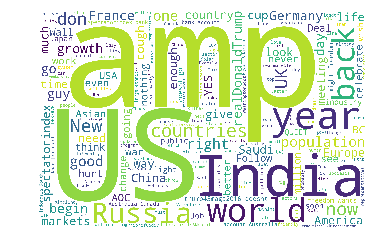

In [10]:
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3600,height=2400,max_words = 200).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Create Negative Score column and Positive column to sort the result

In [11]:
df['Neg_Score'] = df.Fear + df.Negative+ + df.Disgust + df.Sadness

In [12]:
df['Pos_Score'] = df.Trust + df.Positive + df.Joy + df.Anticipation + df.Surprise

In [13]:
df.sort_values(by="Neg_Score" , ascending=False)[:10]

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise,Neg_Score,Pos_Score
User,,,,,,,,,,,
90319452,0.000000,0.000000,0.500000,0.000000,0.00,0.400000,0.000000,0.000000,0.000000,0.900000,0.000000
873367940984324096,0.055556,0.000000,0.111111,0.000000,0.00,0.111111,0.000000,0.055556,0.000000,0.333333,0.000000
876133663750082561,0.117647,0.000000,0.176471,0.000000,0.00,0.000000,0.058824,0.000000,0.000000,0.294118,0.058824
45918501,0.095238,0.047619,0.095238,0.071429,0.00,0.000000,0.000000,0.071429,0.000000,0.261905,0.119048
3940624934,0.076923,0.000000,0.076923,0.000000,0.00,0.025641,0.000000,0.076923,0.025641,0.256410,0.025641
1090315548724842496,0.045455,0.045455,0.136364,0.045455,0.00,0.045455,0.000000,0.000000,0.000000,0.227273,0.090909
888554605151346688,0.041667,0.041667,0.083333,0.041667,0.00,0.041667,0.020833,0.041667,0.000000,0.208333,0.104167
16687474,0.060000,0.040000,0.080000,0.060000,0.04,0.000000,0.020000,0.060000,0.000000,0.200000,0.160000
415039231,0.062500,0.000000,0.062500,0.000000,0.00,0.062500,0.000000,0.000000,0.000000,0.187500,0.000000


In [14]:
neg_user = df.sort_values(by="Neg_Score" , ascending=False)[:10]

In [15]:
neg_count = len(df[(df.Neg_Score>0.0) & (df.Pos_Score<=0.0)])
print('The proportion of user hold negative attitudes accroing to analysis is {:.2%}.'.format(neg_count/len(df)))

The proportion of user hold negative attitudes accroing to analysis is 10.31%.


In [16]:
pos_count = len(df[(df.Neg_Score<=0.0) & (df.Pos_Score>0.0)])
print('The proportion of user hold positive attitudes accroing to analysis is {:.2%}.'.format(pos_count/len(df)))

The proportion of user hold positive attitudes accroing to analysis is 32.99%.


In [17]:
netural_count = len(df[(df.Neg_Score>0.0) & (df.Pos_Score>0.0)])
print('The proportion of user hold positive attitudes accroing to analysis is {:.2%}.'.format(netural_count/len(df)))

The proportion of user hold positive attitudes accroing to analysis is 39.18%.


In [18]:
def get_user_history_text(dataframe):
    consumer_key = 'QZ3xeMG7KYSyUC5SV7Fe5Qp0H'
    consumer_secret = 'Wuf23nMADhcvipBHkJ93haueFC1cNbNH6o2jG8wH7H4ROM1wxB'
    access_token = '994776288232640517-lDoCvNH1vCJBs1hj0nlpXe96SeqLFgV'
    access_token_secret = 'fVkg6aJpaa1Rn6z41pVhhvqCQ8wCLKMclfphgR65emmfJ'
    import tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    user_tweets = dict()
    for i in dataframe.index:
        user_tweets[i] = api.user_timeline(i, count=200,tweet_mode='extended',lang='en')
    user_text = {}
    for i in user_tweets.keys():
        for j in range(len(user_tweets[i])):  
            if i in user_text.keys():  
                user_text[i].append(user_tweets[i][j]._json['full_text'])
            else:  
                user_text[i] = [user_tweets[i][j]._json['full_text']]
    user_tuple = [(k, str(v)) for k, v in user_text.items()]
    return user_tuple

In [19]:
user_tuple = get_user_history_text(neg_user)

In [20]:
user_tuple

[('90319452',
  '[\'@brittanylenay Not from China Buffet *cough cough* @cruisin4Aboozin *cough cough*\', \'@Nekrozach @drugfreekiller Classic\', \'https://t.co/VlbSyEts4D\', \'@ummgeoff @alyssatxylor I owe more than my car is worth sadly :(\', \'Fuck I want a Jeep\', \'@harlee_mcintosh An original by one of the world’s greatest influencers, Mike Tyson\', \'I broke my back\\n\\nMy back is broken \\n\\nSpinal\', \'@cruisin4Aboozin Thank u\', \'@Emmett_Blake_ Still waiting on @netflix to put @BetterCallSaul latest season up\', \'Watching Incredibles 2 for the first time, will inform y’all when I start crying\', \'Breaking up with Alyssa bc she won’t watch breaking bad with me\', \'@Emmett_Blake_ Idk what you just did but I like it\', \'Hangin with my good pal @ffrozzies\', "RT @trilviaplath: hi, it\'s Wednesday my dudes go listen to these cool bands:\\n@knaveryband \\n@beeslyofficial \\n@betteranywayOH \\n@GMATBband \\n@o…", \'@harlee_mcintosh https://t.co/XqyJE9ycgq\', \'I’m exhausted in

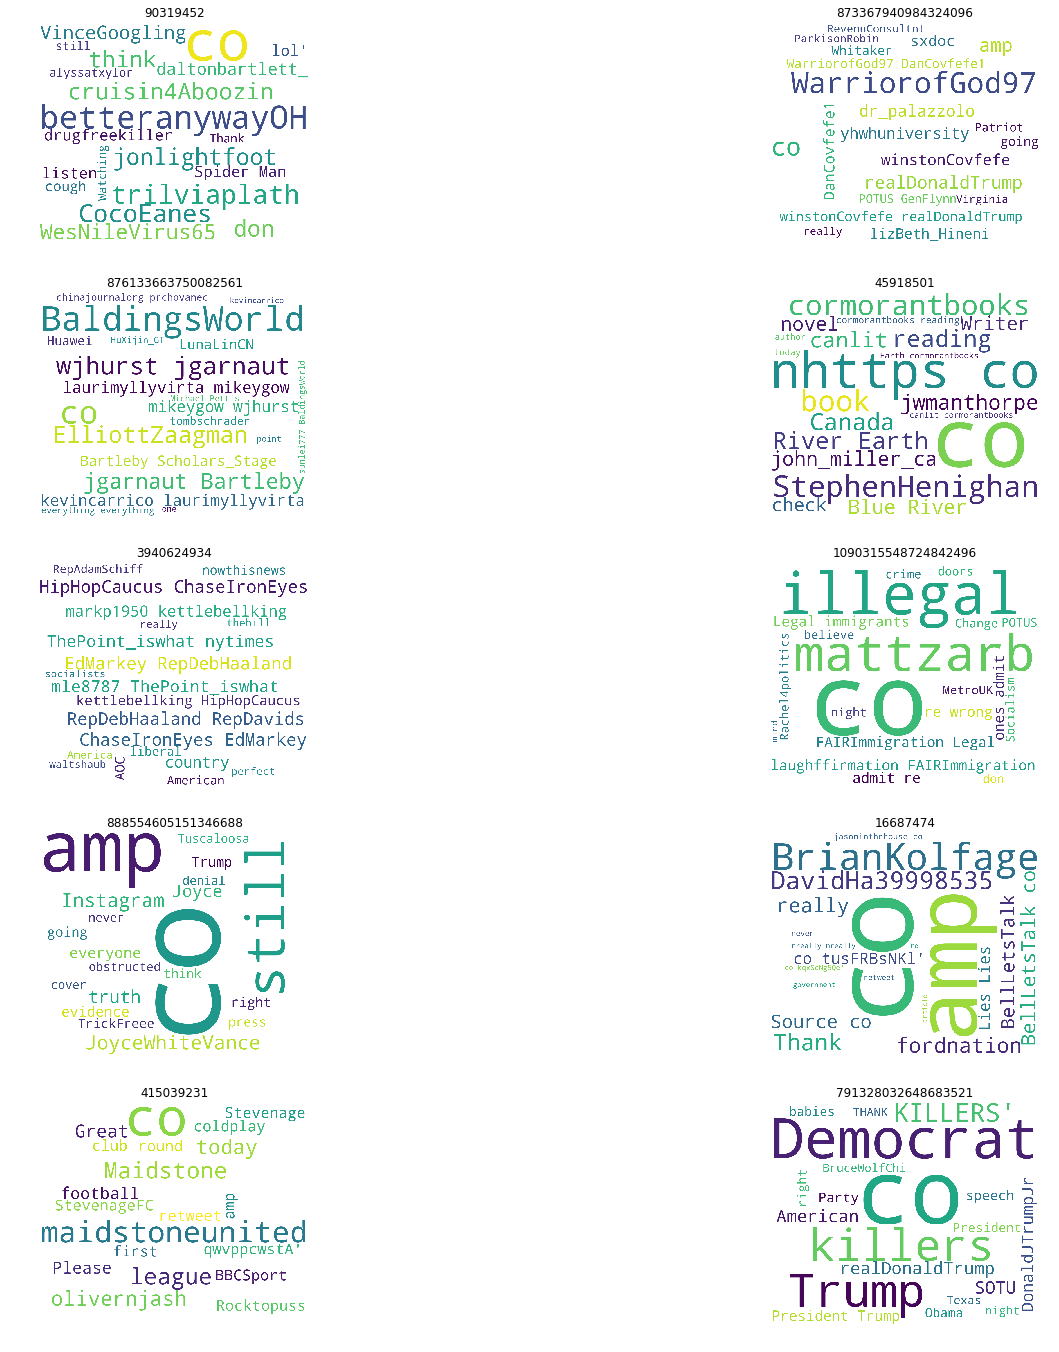

In [21]:
texts = user_tuple
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
#Remove unwanted words
#As we look at the cloud, we can get rid of words that don't make sense by adding them to this variable
DELETE_WORDS = ['people','year','gt','CO']

def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 5
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string


#Set up side by side clouds
COL_NUM = 2
ROW_NUM = 5
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(24,24))

for i in range(0,len(texts)):
    text_string = remove_words(texts[i][1])
    text_string = remove_short_words(text_string)
    ax = axes[i//2, i%2] 
    ax.set_title(texts[i][0])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

## Some Indepth Analysis about the user's attitude

### Generally, around 13.27% users show negative attitudes towards "China" and 37.76% users show negative attitudes, while 33.67% show netural attitudes.
### From the worldCloud result and analysis of their historical twitter results, I have some interesting discoveries about negative concerns:
<ol>
<li>Debate about 'Green New Deal",they think this deal may destory US fuel industry and help China to grow over US</li>
<ul>
<li>https://twitter.com/alexanderbruz/status/1093866653136363520
<li>https://powerthefuture.com/the-day-the-green-new-deal-officially-went-off-the-rails/
</ul>
<li>Argument about 'Trade War'</li>
<ul>
<li>https://twitter.com/nfergus/status/1092075927792566272</li>
</ul>
<li>Supporters of Donald Trump and Republican</li>
<ul>
<li>https://twitter.com/nfergus/status/1092075927792566272</li>
</ul>
</ol>
### The positive parts are bisically regarding Chinese Spring Festival and China economy</h2>

## Potential Improvement for this analysis
<ol>
<li>Application of sentimital analysis of user's historical twitters, to verify whether the users' normal attitude towards things</li>

<li>Tokenize method: Word_tokenize or Sentence_tokenize ? A measurement need to be done</li>

<li>Multilingual NLP package like ployglot can be considered to use</li>

</ol>